In [4]:
%reload_ext autoreload
%autoreload 2

import sys
import os

import numpy as np
import bloscpack as bp
%matplotlib inline

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *
from preprocess_utilities import *
from registration_utilities import *

In [5]:
stack_moving = 'atlasV5'
detector_id = 15

In [6]:
# from sklearn.decomposition.pca import PCA

In [7]:
def find_best_jaccard(hm, hf):
    
    aligner = Aligner4({1: hf}, {1: hm}, labelIndexMap_m2f={1:1})

    aligner.set_centroid(centroid_m='structure_centroid', centroid_f='centroid_m', indices_m=[1])

    gradients = compute_gradient({1: hf}, smooth_first=True)

    aligner.load_gradient(gradients=compute_gradient({1: hf}, smooth_first=True))

    T, scores = aligner.optimize(tf_type='rigid', lr1=1, lr2=0.1)

    # Ts = np.array(aligner.Ts)

    # plt.plot(Ts[:, [0,1,2,4,5,6,8,9,10]]);
    # plt.title('rotational params');
    # plt.xlabel('Iteration');
    # plt.show();

    # plt.plot(Ts[:, [3,7,11]]);
    # plt.title('translation params');
    # plt.xlabel('Iteration');
    # plt.show();

    # print T.reshape((3,4))
    # plt.figure();
    # plt.plot(scores);
    # plt.show();

    # print T.reshape((3,4))

    transform_parameters = {'centroid_m': aligner.centroid_m,
                           'centroid_f': aligner.centroid_f,
                           'domain_f_origin_wrt_wholebrain': np.zeros((3,)),
                           'domain_m_origin_wrt_wholebrain': np.zeros((3,)),
                           'parameters': T}

    hm_aligned, hm_aligned_origin_wrt_hf = transform_volume_by_alignment_parameters(hm.astype(np.int), 
                                                                                    origin=np.array((0,0,0)), 
                                                                                    transform_parameters=transform_parameters)

    hm_aligned = crop_and_pad_volume(hm_aligned, in_origin=hm_aligned_origin_wrt_hf, out_bbox=hf)
    
    return jaccard_masks(hm_aligned, hf, wrt_min=False)

In [108]:
#metrics_allStacks_allStructures_allLevels = defaultdict(lambda: defaultdict(dict))
metrics_allStacks_allStructures = defaultdict(lambda: defaultdict(dict))

for stack_fixed in ['MD585','MD589','MD594']:
        
    for structure in all_known_structures_sided:
        
        try:

            stack_spec = dict(name=stack_fixed,
                       vol_type='annotationAsScore',
                       detector_id=None,
                       prep_id=None,
                       structure=None,
                       resolution='down32')

            ann_vol, ann_vol_origin_wrt_wholebrain_down32Resol = \
            DataManager.load_original_volume_v2(stack_spec, structure=structure, 
                                                bbox_wrt=None,
                                                return_origin_instead_of_bbox=True)        
            ####################

            stack_spec = dict(name=stack_fixed,
                               vol_type='score',
                               detector_id=15,
                               prep_id=2,
                               structure=None,
                               resolution='down32')

            alignedAtlas_vol_m2f = DataManager.load_transformed_volume(stack_m=stack_moving, stack_f=stack_fixed,
                                                            prep_id_f=2,
                                                            detector_id_f=detector_id,
                                                            warp_setting=17, 
                                                           structure=structure)

            alignedAtlas_vol_m2f_origin_wrt_wholebrain_down32Resol = \
                DataManager.get_domain_origin(stack=stack_fixed, domain='brainstem').astype(np.int)            

            ######################
            
            hf = ann_vol > 0

#             xyzs = np.array(np.where(hf))[[1,0,2]]
#             pca = PCA(n_components=3)
#             xyzs_transformed = pca.fit_transform(xyzs.T)
#             principle_axes = pca.components_
#             annotation_centroid = pca.mean_
#             principal_axes_lengths_down32 = xyzs_transformed.max(axis=0) - xyzs_transformed[:, 0].min(axis=0)
#             principal_axes_lengths_um = principal_axes_lengths_down32 * convert_resolution_string_to_voxel_size(resolution='down32', stack=stack_fixed)
#             print stack_fixed, structure
#             print 'principal_axes_lengths_um =', principal_axes_lengths_um
#             del xyzs, xyzs_transformed, pca
            
            hm = crop_and_pad_volume(alignedAtlas_vol_m2f, 
                                     in_origin = alignedAtlas_vol_m2f_origin_wrt_wholebrain_down32Resol - ann_vol_origin_wrt_wholebrain_down32Resol,
                                    out_bbox=(0, hf.shape[1]-1, 0, hf.shape[0]-1, 0, hf.shape[2]-1))
            
#             display_volume_sections(hf, start_level=0, direction='z')
#             display_volume_sections(hm, start_level=0, direction='z')
            
            annVol_centroid_wrt_wholebrain_down32Resol = compute_centroid_3d(hf)
        
#             corr = np.corrcoef(hm.flatten(), hf.flatten())[0,1]
            mask = (hm > 0) | (hf > 0)
            corr = np.corrcoef(hm[mask].flatten(), hf[mask].flatten())[0,1]
        
#             mean_diff = np.sqrt(np.mean(np.abs(hm[mask] - hf[mask])**2))
            mean_diff = np.mean(np.abs(hm[mask].astype(np.float) - hf[mask].astype(np.float)))
            
            print 'corr =', corr, 'mean_diff =', mean_diff
            
            metrics_allStacks_allStructures[stack_fixed][structure] = {'corr': corr, 
         'mean_diff': mean_diff
        }
                        
#             for level in np.arange(0.1, 1, 0.1):
                
# #                 alignedAtlas_centroid_wrt_wholebrain_down32Resol = compute_centroid_3d(hm > level)
                
# #                 centroid_diff_vec_down32 = annVol_centroid_wrt_wholebrain_down32Resol - alignedAtlas_centroid_wrt_wholebrain_down32Resol
# # #                 centroid_diff_percentage = np.dot(principle_axes, centroid_diff_vec_down32) / principal_axes_lengths_down32
# #                 centroid_diff_norm_down32 = np.linalg.norm(centroid_diff_vec_down32)
# #                 centroid_diff_percentage = centroid_diff_norm_down32 / get_structure_length_at_direction(hf, centroid_diff_vec_down32)
                
# #                 centroid_diff_um = np.linalg.norm(centroid_diff_vec_down32) * convert_resolution_string_to_voxel_size(resolution='down32', stack=stack_fixed)
                               
# # #                 jac = jaccard_masks(hm > level, hf, wrt_min=False)
# # #                 best_jac = find_best_jaccard(hm > level, hf)
                
# # #                 print stack_fixed, structure, 'level =', float(level), 'jaccard_min =', jac, 'corr =', corr, 'centroid_diff =', centroid_diff_um, 'um'
# #                 print 'level =', float(level)
# # #                 print 'jaccard =', jac, 'best =', best_jac
# #                 print 'centroid_diff_vec_um =', centroid_diff_um, 'um'
# #                 print 'centroid_diff_percentage =', centroid_diff_percentage
    
#                 metrics_allStacks_allStructures_allLevels[stack_fixed][structure][float(level)] = \
#         {'corr': corr, 
#          'mean_diff': mean_diff, 
#          'jac':jac, 
#          'best_jac': best_jac,
#          'centroid_diff_um': centroid_diff_um, 
#          'centroid_diff_percentage':centroid_diff_percentage
#         }
            
#             print '\n'
            
        except Exception as e:
            sys.stderr.write("Cannot evaluate structure %s: %s\n" % (structure, e))
            continue

corr = 0.7432599973920918 mean_diff = 0.21328481633458907
corr = 0.7020694103971966 mean_diff = 0.23449658670477008
corr = 0.5601273027807117 mean_diff = 0.27398841235889926
corr = 0.6811214103099705 mean_diff = 0.21141479418695439
corr = 0.8056035039340409 mean_diff = 0.18727121581014902
corr = 0.7987230515926764 mean_diff = 0.19374539982423195
corr = 0.6505532897912865 mean_diff = 0.23186618433398748
corr = 0.6262223692084187 mean_diff = 0.24019520652099513
corr = 0.47197604348508604 mean_diff = 0.29882277161762166
corr = 0.30068634105707637 mean_diff = 0.27656358374469775
corr = 0.5307174040570172 mean_diff = 0.26851922367589937
corr = 0.5689209382314316 mean_diff = 0.26813586962444474
corr = 0.5941591462801118 mean_diff = 0.24923169774080442
corr = 0.6250787707610312 mean_diff = 0.25378502856073554
corr = 0.7865398912638989 mean_diff = 0.2021664620333884
corr = 0.7653682173377527 mean_diff = 0.20456294183705334
corr = 0.6068981613657032 mean_diff = 0.2506257277886565
corr = 0.79719

File does not exist: /home/yuncong/CSHL_volumes/MD585/MD585_down32_annotationAsScoreVolume/score_volumes/MD585_down32_annotationAsScoreVolume_Sp5C_R.bp
Cannot evaluate structure Sp5C_R: [Errno 2] No such file or directory: '/home/yuncong/CSHL_volumes/MD585/MD585_down32_annotationAsScoreVolume/score_volumes/MD585_down32_annotationAsScoreVolume_Sp5C_R.bp'


corr = 0.5178469932433318 mean_diff = 0.2267888435136186
corr = 0.7453690809524939 mean_diff = 0.17851200403158904
corr = 0.7617230366156482 mean_diff = 0.20190970124996238
corr = 0.778189784997159 mean_diff = 0.18915544592307604
corr = 0.7836431745119609 mean_diff = 0.20271964956834207
corr = 0.8344588990786486 mean_diff = 0.1831348324938667
corr = 0.6429358634581633 mean_diff = 0.2226238258460498
corr = 0.5814337708005574 mean_diff = 0.26006331140699346
corr = 0.7132481906575574 mean_diff = 0.20926053941947406
corr = 0.6177724342932264 mean_diff = 0.26849458062086173
corr = 0.6511859770075118 mean_diff = 0.23543497785706696
corr = 0.8565362022641972 mean_diff = 0.17423216864787525
corr = 0.7722108955721962 mean_diff = 0.2112483607310492
corr = 0.7739577023705676 mean_diff = 0.2033834890467251
corr = 0.704789428349497 mean_diff = 0.23705346313005493
corr = 0.672358299887836 mean_diff = 0.23613255248790033
corr = 0.6635280738969245 mean_diff = 0.25453217432414965
corr = 0.7583563979945

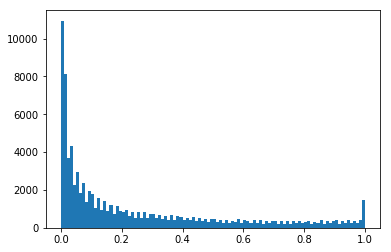

In [99]:
plt.hist(np.abs(hm[mask] - hf[mask]), bins=100);

In [14]:
metrics_allStacks_allStructures_allLevels.default_factory = None

In [15]:
fp = '/home/yuncong/CSHL_registration_metrics/metrics_allStacks_allStructures_allLevels.pkl'
create_parent_dir_if_not_exists(fp)
save_pickle(metrics_allStacks_allStructures_allLevels, fp)

In [8]:
fp = '/home/yuncong/CSHL_registration_metrics/metrics_allStacks_allStructures_allLevels.pkl'
metrics_allStacks_allStructures_allLevels = load_pickle(fp)

In [10]:
diffperc_all_stacks_all_structures = \
{stack: {s: np.nanmin([v['centroid_diff_um'] for l, v in x_all_l.iteritems()]) for s, x_all_l in x_all_s_all_l.iteritems()}
 for stack, x_all_s_all_l in metrics_allStacks_allStructures_allLevels.iteritems()}

In [13]:
np.median([y for x in diffperc_all_stacks_all_structures.values() for y in x.values()])

62.60149319399443

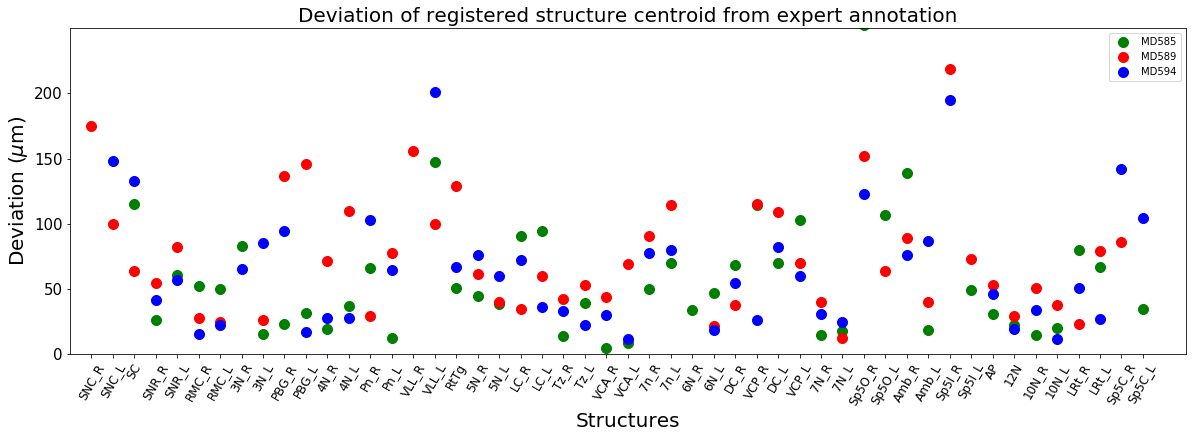

In [26]:
plot_by_stack_by_structure(diffperc_all_stacks_all_structures, 
                           structures=structures_sided_sorted_by_rostral_caudal_position,
                           yticks=np.arange(0, 250, 50), 
                           yticklabel_fmt='%d',
                           ylabel='Deviation ($\mu$m)',
                          title='Deviation of registered structure centroid from expert annotation',
                          stack_to_color={'MD589':(255,0,0), 'MD585': (0,127,0), 'MD594': (0,0,255)})

In [131]:
diffperc_all_stacks_all_structures = \
{stack: {s: np.nanmin([v['centroid_diff_percentage'] for l, v in x_all_l.iteritems()]) for s, x_all_l in x_all_s_all_l.iteritems()}
 for stack, x_all_s_all_l in metrics_allStacks_allStructures_allLevels.iteritems()}

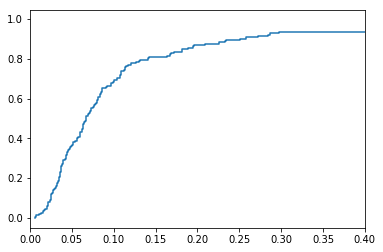

In [135]:
sorted_data = np.sort(([y for x in diffperc_all_stacks_all_structures.values() for y in x.values()]))
plt.step(sorted_data, np.arange(sorted_data.size)/float(len(sorted_data)));  # From 0 to the number of data points-1
plt.xlim([0, 0.4]);
# plt.step(sorted_data[::-1], np.arange(sorted_data.size))  # From the number of data points-1 to 0

In [132]:
np.median([y for x in diffperc_all_stacks_all_structures.values() for y in x.values()])

0.06693369811432645

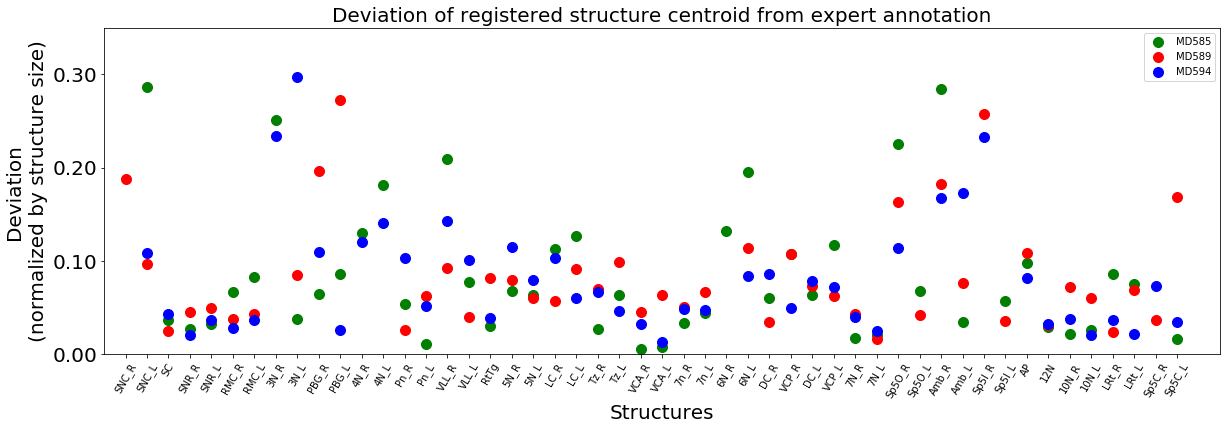

In [134]:
plot_by_stack_by_structure(diffperc_all_stacks_all_structures, 
                           structures=structures_sided_sorted_by_rostral_caudal_position,
                           ylim=[0, 0.35], 
                           yspacing=.1,
                           ylabel='Deviation \n(normalized by structure size)',
                          title='Deviation of registered structure centroid from expert annotation',
                          stack_to_color={'MD589':(255,0,0), 'MD585': (0,127,0), 'MD594': (0,0,255)})

In [116]:
meandiff_all_stacks_all_structures = \
{stack: {s: x['mean_diff']
         for s, x in x_all_s.iteritems()}
 for stack, x_all_s in metrics_allStacks_allStructures.iteritems()}

In [127]:
np.median([y for x in meandiff_all_stacks_all_structures.values() for y in x.values()])

0.23508416238474567

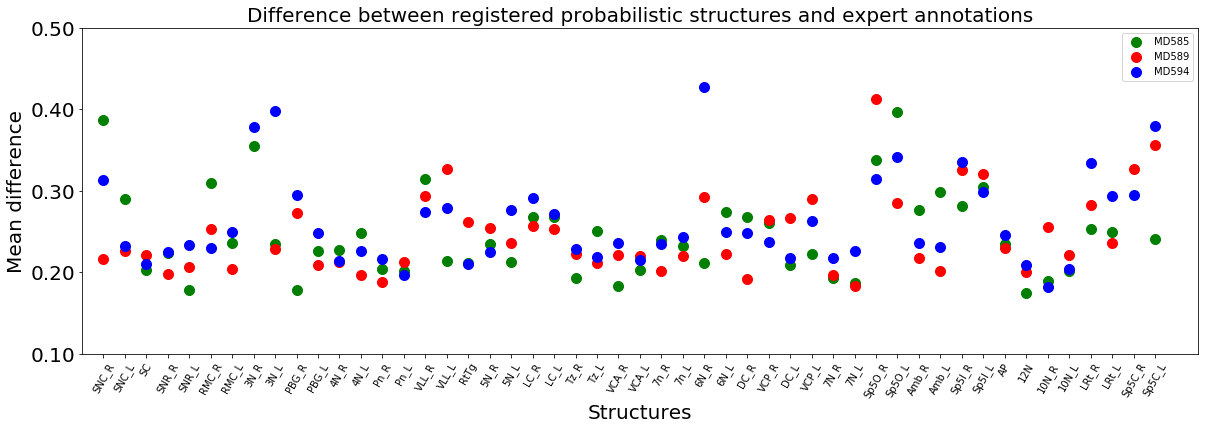

In [126]:
plot_by_stack_by_structure(meandiff_all_stacks_all_structures, 
                           structures=structures_sided_sorted_by_rostral_caudal_position,
                           ylim=[0.1, 0.5], 
                           yspacing=.1,
                           ylabel='Mean difference',
                          title='Difference between registered probabilistic structures and expert annotations',
                          stack_to_color={'MD589':(255,0,0), 'MD585': (0,127,0), 'MD594': (0,0,255)})